## Training script for the CNN 

Loads in the converted plane representation of the pgn files, defines the network architecture and starts the training process. Checkpoints of the weights are saved if there's an improvement in the validation loss.
The training performance metrics (e.g. losses, accuracies...) are exported to tensorboard and can be checked during training.
* author: QueensGambit

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from __future__ import print_function
import sys
sys.path.insert(0,'../../../')
from DeepCrazyhouse.src.runtime.ColorLogger import enable_color_logging
import logging
import mxnet as mx
from mxnet import gluon
from mxnet import autograd as ag
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime
import random
from DeepCrazyhouse.src.domain.crazyhouse.input_representation import board_to_planes, planes_to_board
from DeepCrazyhouse.src.domain.crazyhouse.output_representation import policy_to_moves, policy_to_best_move, policy_to_move
from DeepCrazyhouse.src.preprocessing.dataset_loader import load_pgn_dataset
import chess
import re
from time import time
from DeepCrazyhouse.src.domain.neural_net.architectures.AlphaZeroResnet import AlphaZeroResnet
from DeepCrazyhouse.src.domain.neural_net.architectures.Rise import Rise
from DeepCrazyhouse.src.preprocessing.PGNRecordDataset import PGNRecordDataset
from DeepCrazyhouse.configs.main_config import main_config
from mxboard import SummaryWriter
from tqdm import tqdm_notebook
import os
from mxnet import nd, autograd
from collections import deque
from copy import deepcopy
from multiprocessing import cpu_count
from DeepCrazyhouse.configs.main_config import main_config
from DeepCrazyhouse.src.training.TrainerAgent import TrainerAgent, evaluate_metrics, acc_sign, reset_metrics

from DeepCrazyhouse.src.training.lr_schedules.lr_schedules import *
import glob

enable_color_logging()
%matplotlib inline

2019-01-14 08:33:52 matplotlib.pyplot[27985] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Settings

In [4]:
# set the context on CPU, switch to GPU if there is one available (strongly recommended for training)
ctx = mx.gpu()
# set a specific seed value for reproducability
seed = 72

export_weights = True
log_metrics_to_tensorboard = True
export_grad_histograms = True

# batch_steps = 1000 means for example that every 1000 batches the validation set gets processed
batch_steps = 1000 # this defines how often a new checkpoint will be saved and the metrics evaluated
# k_steps_initial defines how many steps have been trained before
# (k_steps_initial != 0 if you continue training from a checkpoint)
k_steps_initial = 0
# this is the network based on human play
symbol_file = 'model-1.32459-0.566-symbol.json'
params_file = 'model-1.32459-0.566-0074.params'

batch_size = 1024 # the batch_size needed to be reduced to 1024 in order to fit in the GPU 1080Ti
#4096 was originally used in the paper -> works slower for current GPU
# 2048 was used in the paper Mastering the game of Go without human knowledge and fits in GPU memory
#typically if you half the batch_size, you should double the lr

# otimization parameters
max_lr = 0.0005
min_lr = 0.00001

max_momentum = 0.95
min_momentum = 0.8
# loads a previous checkpoint if the loss increased significanly
use_spike_recovery = True
# stop training as soon as max_spikes has been reached
max_spikes = 20
# define spike threshold when the detection will be triggered
spike_thresh = 1.5
# weight decay
wd = 3e-5 #1e-4
# weight the value loss a lot lower than the policy loss in order to prevent overfitting
val_loss_factor = 0.5
policy_loss_factor = 0.5

normalize = True # define whether to normalize input data to [0,1]
nb_epochs = 1 # define how many epoches the network will be trained

In [5]:
# Fixing the random seed
mx.random.seed(seed)

### Create a ./logs and ./weights directory

In [6]:
!mkdir ./logs && mkdir ./weights

mkdir: cannot create directory ‘./weights’: File exists


### load the config file

In [7]:
print(main_config)

{'pgn_train_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/pgn/train/', 'pgn_val_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/pgn/val/', 'pgn_test_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/pgn/test/', 'pgn_mate_in_one_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/pgn/mate_in_one/', 'planes_train_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/planes/train/', 'planes_val_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/planes/val/', 'planes_test_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/planes/test/', 'planes_mate_in_one_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/planes/mate_in_one/', 'rec_dir': '/media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/rec/', 'model_

In [8]:
CPU_COUNT = cpu_count()
CPU_COUNT

16

### load the dataset-files

### Validation Dataset (which is used during training)

In [9]:
s_idcs_val, x_val, yv_val, yp_val, pgn_datasets_val = load_pgn_dataset(dataset_type='val', part_id=0,
                                                                           print_statistics=True, print_parameters=True, normalize=normalize)
val_dataset = gluon.data.ArrayDataset(nd.array(x_val), nd.array(yv_val), nd.array(yp_val.argmax(axis=1)))
val_data = gluon.data.DataLoader(val_dataset, batch_size, shuffle=False, num_workers=CPU_COUNT)

2019-01-14 08:33:56 root[27985] DEBUG loading: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/planes/val/2019-01-13-15-49-43/sf_vs_sf_cz_validation_0.zip...
2019-01-14 08:33:56 root[27985] DEBUG 
2019-01-14 08:33:56 root[27985] INFO STATISTICS:
black_wins [324]
draws [25]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [651]
2019-01-14 08:33:56 root[27985] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'sf_vs_sf_cz_validation.pgn']
termination_conditions [b'Normal']


In [10]:
nb_parts = len(glob.glob(main_config['planes_train_dir'] + '**/*'))

In [11]:
nb_it_per_epoch = (len(x_val) * nb_parts) // batch_size # calculate how many iterations per epoch exist
# one iteration is defined by passing 1 batch and doing backprop
total_it = int(nb_it_per_epoch * nb_epochs)

### Define a Learning Rate schedule
* Here we apply a fine tuning schedule with a very low learning rate

2019-01-14 08:33:58 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:58 matplotlib.font_manager[27985] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/queensgambit/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-01-14 08:33:58 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:58 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:58 matplotlib.axes._base[27985] DEBUG update_title_pos


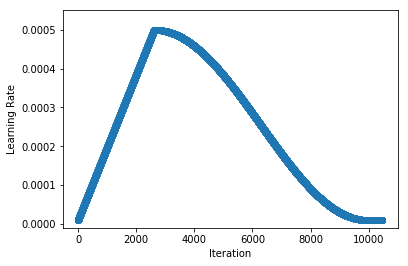

In [12]:
lr_schedule = CosineAnnealingSchedule(min_lr, max_lr, total_it*.7)
lr_schedule = LinearWarmUp(lr_schedule, start_lr=min_lr, length=total_it*.25)
plot_schedule(lr_schedule, iterations=total_it, ylim=[-min_lr, max_lr*1.1])

### Momentum schedule

2019-01-14 08:33:58 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:59 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:59 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 08:33:59 matplotlib.axes._base[27985] DEBUG update_title_pos


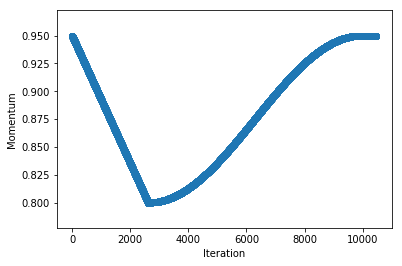

In [13]:
momentum_schedule = MomentumSchedule(lr_schedule, min_lr, max_lr, min_momentum, max_momentum)
plot_schedule(momentum_schedule, iterations=total_it, ylabel='Momentum')

### Create the model

In [14]:
input_shape = x_val[0].shape

In [15]:
input_shape

(34, 8, 8)

In [16]:
yp_val.shape

(90102, 2272)

In [17]:
try:
    del net
except:
    pass

### Load the pretrained model

In [18]:
net = gluon.nn.SymbolBlock.imports(symbol_file='weights/%s'%symbol_file, input_names='data', param_file='weights/%s'%params_file, ctx=ctx)

In [19]:
#net = Rise(n_labels=yp_val.shape[1], channels=256, channels_value_head=8, channels_policy_head=16, nb_res_blocksX=7, nb_res_blocksX_neck=12, cardinality=1, cardinality_neck=2, value_fc_size=256, bn_mom=0.9, act_type='lrelu', use_se=True, res_scale_fac=0.2, use_rise_stem=False)

## Network summary

In [20]:
print(net)

SymbolBlock(

)


mx.viz.plot_network(
    net(mx.sym.var('data'))[1], 
    shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
    node_attrs={"shape":"oval","fixedsize":"false"}
)


In [21]:
mx.viz.print_summary(
    net(mx.sym.var('data'))[1], 
    shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                          34x8x8                  0                                           
________________________________________________________________________________________________________________________
stem_conv0_fwd(Convolution)                         256x8x8                 78336       data                            
________________________________________________________________________________________________________________________
stem_batchnorm0_fwd(BatchNorm)                      256x8x8                 512         stem_conv0_fwd                  
________________________________________________________________________________________________________________________
stem_leakyrelu0_fwd(LeakyReLU)  

## Initialize the weights 
(only needed if no pretrained weights are used)

In [22]:
#net.collect_params().initialize(mx.init.Xavier(rnd_type='uniform', factor_type='avg', magnitude=2.24), ctx=ctx)
#net.hybridize()

## Define the metrics to use

In [23]:
metrics = {
    'value_loss': mx.metric.MSE(name='value_loss', output_names=['value_output']),
    'policy_loss': mx.metric.CrossEntropy(name='policy_loss', output_names=['policy_output'],
                                                label_names=['policy_label']),
    'value_acc_sign': mx.metric.create(acc_sign, name='value_acc_sign', output_names=['value_output'],
                                             label_names=['value_label']),
    'policy_acc': mx.metric.Accuracy(axis=1, name='policy_acc', output_names=['policy_output'],
                                           label_names=['policy_label'])
}

## Define a training agent

In [24]:
train_agent = TrainerAgent(net, val_data, nb_parts, lr_schedule, momentum_schedule, total_it, wd=wd, batch_steps=batch_steps,
                 k_steps_initial=k_steps_initial, cpu_count=CPU_COUNT-3, batch_size=batch_size, normalize=normalize, export_weights=export_weights,
                 export_grad_histograms=export_grad_histograms, log_metrics_to_tensorboard=log_metrics_to_tensorboard, ctx=ctx, metrics=metrics,
                use_spike_recovery=use_spike_recovery, max_spikes=max_spikes, spike_thresh=spike_thresh, seed=seed, val_loss_factor=val_loss_factor, policy_loss_factor=policy_loss_factor)

## Performance Pre-Training

In [25]:
evaluate_metrics(metrics, val_data, net, nb_batches=None)

{'loss': 1.3245868513753298,
 'policy_acc': 0.5659807773412355,
 'policy_loss': 1.333343154288421,
 'value_acc_sign': 0.815362753482495,
 'value_loss': 0.45771286297928204}

## Start the training process

In [26]:
(k_steps_final, val_loss_final, val_p_acc_final), (k_steps_best, val_loss_best, val_p_acc_best) = train_agent.train()

2019-01-14 08:34:16 root[27985] INFO EPOCH 1
2019-01-14 08:34:16 root[27985] INFO =========================


A Jupyter Widget

2019-01-14 08:41:31 root[27985] INFO Step 1K/10K - 434ms/step
2019-01-14 08:41:31 root[27985] INFO -------------------------
2019-01-14 08:41:31 root[27985] DEBUG Iteration 1000/10470
2019-01-14 08:41:31 root[27985] DEBUG lr: 0.0001970 - momentum: 0.8927507
 - train_loss: 1.1593 - train_value_loss: 0.4343 - train_policy_loss: 1.1667 - train_value_acc_sign: 0.8324 - train_policy_acc: 0.6121 - val_loss: 1.3287 - val_value_loss: 0.4537 - val_policy_loss: 1.3376 - val_value_acc_sign: 0.8170 - val_policy_acc: 0.5654
2019-01-14 08:41:49 root[27985] INFO Saved checkpoint to ./weights/model-1.32875-0.565-0001.params
 - 452s
2019-01-14 08:48:58 root[27985] INFO Step 2K/10K - 429ms/step
2019-01-14 08:48:58 root[27985] INFO -------------------------
2019-01-14 08:48:58 root[27985] DEBUG Iteration 2000/10470
2019-01-14 08:48:58 root[27985] DEBUG lr: 0.0003842 - momentum: 0.8354441
 - train_loss: 1.1163 - train_value_loss: 0.4570 - train_policy_loss: 1.1229 - train_value_acc_sign: 0.8228 - train_po

A Jupyter Widget

2019-01-14 09:56:19 root[27985] INFO Step 11K/10K - 181ms/step
2019-01-14 09:56:19 root[27985] INFO -------------------------
2019-01-14 09:56:19 root[27985] DEBUG Iteration 11000/10470
2019-01-14 09:56:19 root[27985] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 1.1249 - train_value_loss: 0.4123 - train_policy_loss: 1.1321 - train_value_acc_sign: 0.8347 - train_policy_acc: 0.6197 - val_loss: 1.3269 - val_value_loss: 0.4407 - val_policy_loss: 1.3358 - val_value_acc_sign: 0.8218 - val_policy_acc: 0.5658
2019-01-14 09:56:38 root[27985] INFO Saved checkpoint to ./weights/model-1.32689-0.566-0011.params
 - 200s
2019-01-14 09:56:38 root[27985] DEBUG The number of given iterations has been reached

Elapsed time for training(hh:mm:ss): 1:22:22


## Export the last model state

In [27]:
# export the model via mxnet checkpoint
prefix ="./weights/model-%.5f-%.3f" % (val_loss_final, val_p_acc_final)
# the export function saves both the architecture and the weights
net.export(prefix, epoch=k_steps_final) 

In [28]:
prefix

'./weights/model-1.32689-0.566'

## Load the best model once again

In [29]:
# delete the current net object form memory
del net

In [30]:
model_prefix ="./weights/model-%.5f-%.3f" % (val_loss_best, val_p_acc_best)
model_arch_path = '%s-symbol.json' % model_prefix
model_params_path = '%s-%04d.params' % (model_prefix, k_steps_best)
print('load current best model:', model_params_path)
#net.load_parameters(model_path, ctx=ctx)
net = gluon.nn.SymbolBlock.imports(model_arch_path, ['data'], model_params_path, ctx=ctx)

load current best model: ./weights/model-1.32689-0.566-0011.params


In [31]:
print('best val_loss: %.5f with v_policy_acc: %.5f at k_steps_best %d' % (val_loss_best, val_p_acc_best, k_steps_best))

best val_loss: 1.32689 with v_policy_acc: 0.56576 at k_steps_best 11


In [32]:
idx = 0

white
[CrazyhousePocket(''), CrazyhousePocket('')]


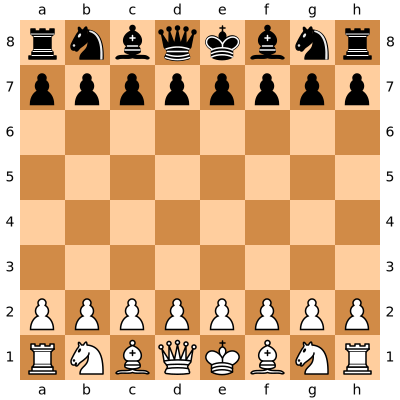

In [33]:
board = planes_to_board(x_val[idx], normalized_input=normalize)

print(chess.COLOR_NAMES[board.turn])
print(board.pockets)
board

In [34]:
def predict_single(net, x):
    
    out = [None, None]
    pred = net(mx.nd.array(np.expand_dims(x, axis=0), ctx=ctx))
    pred[1] = pred[1].softmax()
    out[0] = pred[0].asnumpy()
    out[1] = pred[1].asnumpy()
    
    return out

In [35]:
pred = predict_single(net, x_val[0])
pred

[array([[0.35026672]], dtype=float32),
 array([[5.6201378e-07, 1.4013824e-07, 6.8070072e-08, ..., 7.8934811e-08,
         2.6777805e-08, 7.9790809e-08]], dtype=float32)]

In [36]:
policy_to_best_move(board, yp_val[idx])

(Move.from_uci('e2e4'), 1.0)

In [37]:
opts = 5
selected_moves, probs = policy_to_moves(board, pred[1][0])
selected_moves[:opts]

[Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b2b3')]

[Text(0, 0, 'e2e4'),
 Text(0, 0, 'd2d4'),
 Text(0, 0, 'g1f3'),
 Text(0, 0, 'b1c3'),
 Text(0, 0, 'b2b3')]

2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos


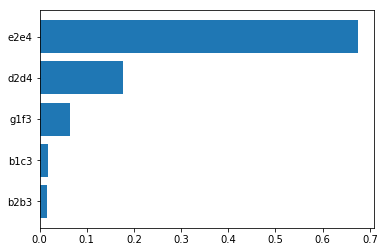

In [38]:
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves)

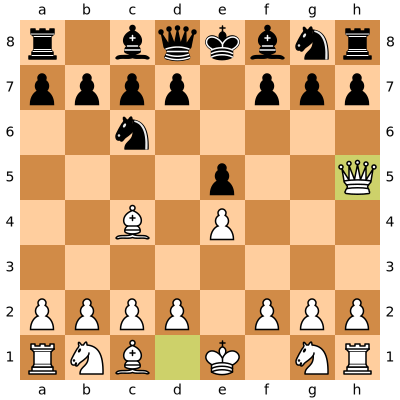

In [39]:
board = chess.variant.CrazyhouseBoard()
board.push_uci('e2e4')
board.push_uci('e7e5')
board.push_uci('f1c4')
board.push_uci('b8c6')
board.push_uci('d1h5')
x_scholar_atck = board_to_planes(board, normalize=normalize)
board

[Text(0, 0, 'g7g6'),
 Text(0, 0, 'd8e7'),
 Text(0, 0, 'f8c5'),
 Text(0, 0, 'g8f6'),
 Text(0, 0, 'd7d5')]

2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:56:40 matplotlib.axes._base[27985] DEBUG update_title_pos


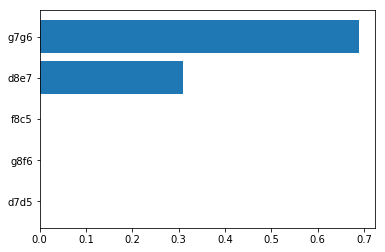

In [40]:
pred = predict_single(net, x_scholar_atck)

selected_moves, probs = policy_to_moves(board, pred[1][0])
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves)

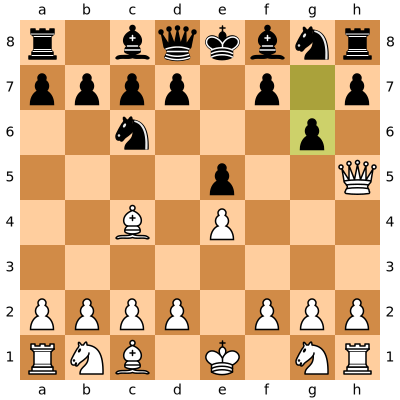

In [41]:
board.push(selected_moves[0])
board

### Performance on test dataset


In [42]:
s_idcs_test, x_test, yv_test, yp_test, pgn_datasets_test = load_pgn_dataset(dataset_type='test', part_id=0,
                                                                           print_statistics=True, print_parameters=True, normalize=True)
test_dataset = gluon.data.ArrayDataset(nd.array(x_test), nd.array(yv_test), nd.array(yp_test.argmax(axis=1)))
test_data = gluon.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=CPU_COUNT)

2019-01-14 09:56:44 root[27985] DEBUG loading: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/stockfish/Crazyhouse/planes/test/2019-01-13-15-49-50/sf_vs_sf_cz_test_0.zip...
2019-01-14 09:56:44 root[27985] DEBUG 
2019-01-14 09:56:45 root[27985] INFO STATISTICS:
black_wins [307]
draws [19]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [674]
2019-01-14 09:56:45 root[27985] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'sf_vs_sf_cz_test.pgn']
termination_conditions [b'Normal']


















In [43]:
evaluate_metrics(metrics, test_data, net, nb_batches=None)

{'loss': 1.3282656887348745,
 'policy_acc': 0.5653507557721057,
 'policy_loss': 1.3372199019933748,
 'value_acc_sign': 0.8253287462886418,
 'value_loss': 0.4417985761433505}

### Show result on mate-in-one problems

In [44]:
s_idcs_mate, x_mate, yv_mate, yp_mate, pgn_dataset_mate = load_pgn_dataset(dataset_type='mate_in_one',
                                                         print_parameters=True, print_statistics=True, normalize=normalize)

2019-01-14 09:57:01 root[27985] DEBUG loading: /media/queensgambit/5C483A84483A5CC8/Deep_Learning/data/lichess/Crazyhouse/planes/mate_in_one/2018-09-27-12-37-30/lichess_db_crazyhouse_rated_2018-04_0.zip...
2019-01-14 09:57:01 root[27985] DEBUG 
2019-01-14 09:57:01 root[27985] INFO STATISTICS:
black_wins [429]
draws [0]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [571]
2019-01-14 09:57:01 root[27985] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-04.pgn']
termination_conditions [b'Normal']


In [45]:
mate_dataset = mx.gluon.data.dataset.ArrayDataset(nd.array(x_mate), nd.array(yv_mate), nd.array(yp_mate.argmax(axis=1)))
mate_data = mx.gluon.data.DataLoader(mate_dataset, batch_size=batch_size, num_workers=CPU_COUNT)

### Mate In One Performance

In [46]:
#mod_p.score(mate_iter, metrics)
evaluate_metrics(metrics, mate_data, net)

{'loss': 0.693085176538229,
 'policy_acc': 0.781,
 'policy_loss': 0.6988338012695312,
 'value_acc_sign': 0.956,
 'value_loss': 0.12397132813930511}

### Show some example mate problems

In [47]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [48]:
#from DeepCrazyhouse.src.domain.crazyhouse.legal_move_filter import mirror_move

### Evaluate Performance

In [49]:
def eval_pos(net, x_mate, yp_mate, verbose=False):
    
    board = planes_to_board(x_mate, normalized_input=normalize)
    if verbose is True:
        print("{0}'s turn".format(chess.COLOR_NAMES[board.turn]))
        print("black/white {0}".format(board.pockets))
    pred = predict_single(net, x_mate)
    
    
    #true_mat = yp_mate.reshape(78,8,8)
    #true_move = filter_moves(board, true_mat, is_white_to_move=board.turn, renormalize_confidences=False)[0][0]
    true_move = policy_to_move(yp_mate, is_white_to_move=board.turn)
    
    #pred_mat = pred[1][0].reshape(78,8,8)
    opts = 5
    pred_moves, probs = policy_to_moves(board, pred[1][0])
    pred_moves = pred_moves[:opts]
    
    #pred_moves = filter_moves(board, pred_mat, is_white_to_move=board.turn, renormalize_confidences=False)[0][:opts]

    legal_move_cnt = board.legal_moves.count()
    mate_move_cnt = str(board.legal_moves).count('#')
    
    is_mate_5_top = False
    
    for pred_move in pred_moves:
        board_5_top = deepcopy(board)
        board_5_top.push(pred_move)
        if board_5_top.is_checkmate() is True:
            is_mate_5_top = True
            break
    
    board.push(pred_moves[0])
    
    is_checkmate = False
    if board.is_checkmate() is True:
        is_checkmate = True
        
    filtered_pred = sorted(pred[1][0], reverse=True)
    
    if verbose is True:
        plt.barh(range(opts)[::-1], filtered_pred[:opts])
        ax = plt.gca()
        ax.set_yticks(range(opts)[::-1])
        ax.set_yticklabels(pred_moves)
        plt.title('True Move:' + str(true_move) +
                 '\nEval:' + str(pred[0][0]))
        plt.show()
    
    return pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt

In [50]:
nb_pos = len(x_mate)
mates_found = []
mates_5_top_found = []
legal_mv_cnts = []
mate_mv_cnts = []

for i in range(nb_pos):
    pred, pred_moves, true_move, board, is_mate, is_mate_5_top, legal_mv_cnt, mate_mv_cnt= eval_pos(net, x_mate[i], yp_mate[i])
    mates_found.append(is_mate)
    legal_mv_cnts.append(legal_mv_cnt)
    mate_mv_cnts.append(mate_mv_cnt)
    mates_5_top_found.append(is_mate_5_top)

In [51]:
np.array(mate_mv_cnts).mean()

1.623

In [52]:
np.array(legal_mv_cnts).mean()

115.817

### Random Guessing Baseline

In [53]:
np.array(mate_mv_cnts).mean() / np.array(legal_mv_cnts).mean()

0.014013486793821289

### Prediciton Performance

In [54]:
print('mate_in_one_acc:', sum(mates_found) / nb_pos)

mate_in_one_acc: 0.957


In [55]:
sum(mates_5_top_found) / nb_pos

0.998

In [56]:
pgn_dataset_mate.tree()

/
 ├── metadata (1001, 17) |S128
 ├── parameters
 │   ├── batch_size (1,) int16
 │   ├── compression (1,) |S4
 │   ├── limit_nb_games (1,) int16
 │   ├── max_nb_files (1,) int16
 │   ├── min_elo_both (1,) int16
 │   ├── pgn_name (1,) |S40
 │   └── termination_conditions (1,) |S6
 ├── start_indices (1000,) int32
 ├── statistics
 │   ├── black_wins (1,) int16
 │   ├── draws (1,) int16
 │   ├── game_idx_end (1,) int16
 │   ├── game_idx_start (1,) int16
 │   ├── number_selected_games (1,) int16
 │   └── white_wins (1,) int16
 ├── x (1000, 34, 8, 8) int16
 ├── y_policy (1000, 2272) int16
 └── y_value (1000,) int16

In [57]:
metadata = np.array(pgn_dataset_mate['metadata'])
metadata[0, :]
metadata[1, :]

array([b'Event', b'Site', b'Date', b'Round', b'White', b'Black',
       b'Result', b'BlackElo', b'BlackRatingDiff', b'BlackTitle',
       b'Termination', b'TimeControl', b'UTCDate', b'UTCTime', b'Variant',
       b'WhiteElo', b'WhiteRatingDiff'], dtype='|S128')

array([b'Rated Crazyhouse tournament https://lichess.org/tournament/EkplkgHV',
       b'https://lichess.org/6XtZaN95', b'2018.03.31', b'-', b'mrsjadk26',
       b'beatles_21', b'1-0', b'2101', b'-11', b'FM', b'Normal', b'180+0',
       b'2018.03.31', b'22:00:44', b'Crazyhouse', b'2158', b'+11'],
      dtype='|S128')

In [58]:
site_mate = metadata[1:, 1]

In [59]:
def clean_string(np_string):
    string = str(site_mate[i]).replace("b'", "")
    string = string.replace("'", "")
    string = string.replace('"', '')
    
    return string

In [60]:
import chess.svg
from IPython.display import SVG, HTML

## Show the result of the first 17 examples

https://lichess.org/6XtZaN95
white's turn
black/white [CrazyhousePocket('qbnp'), CrazyhousePocket('rn')]
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.font_manager[27985] DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/queensgambit/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos


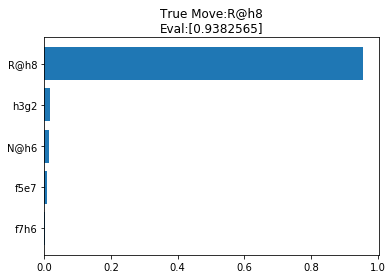

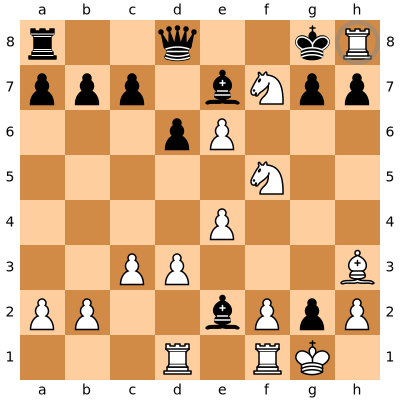

https://lichess.org/aGh9J93k
white's turn
black/white [CrazyhousePocket('qbp'), CrazyhousePocket('rbbbnnn')]
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos


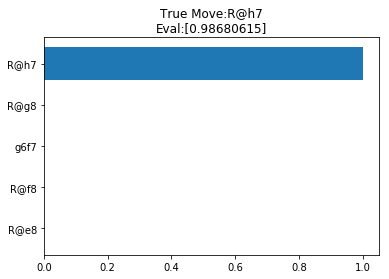

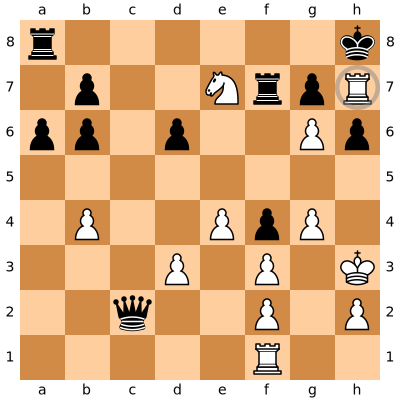

https://lichess.org/N65IVIw4
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnnpppp')]
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos


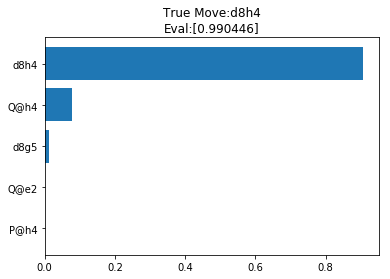

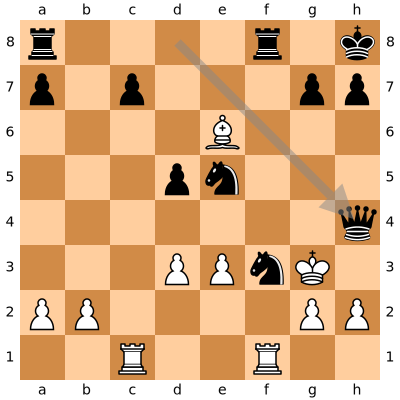

https://lichess.org/zr1Y3Yk0
black's turn
black/white [CrazyhousePocket('npp'), CrazyhousePocket('rbbnnp')]
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:24 matplotlib.axes._base[27985] DEBUG update_title_pos


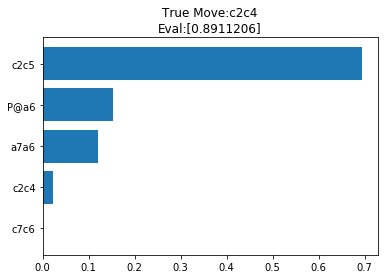

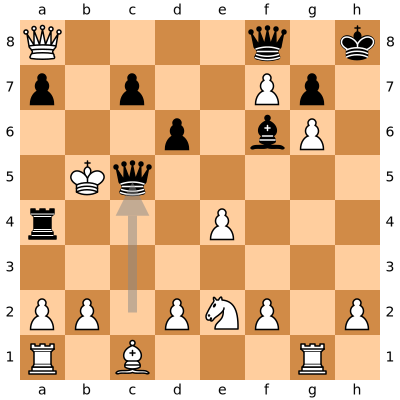

https://lichess.org/BcOhX1Tf
black's turn
black/white [CrazyhousePocket('pp'), CrazyhousePocket('qrrbbbnnpp')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


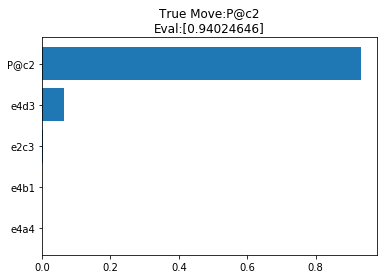

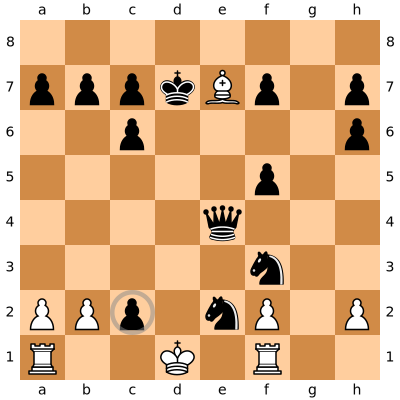

https://lichess.org/NgHPT61x
white's turn
black/white [CrazyhousePocket('qrnppp'), CrazyhousePocket('bnp')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


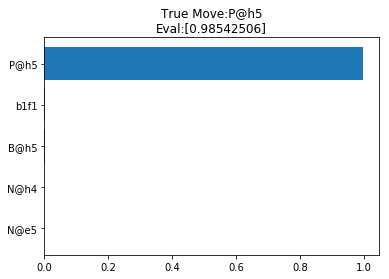

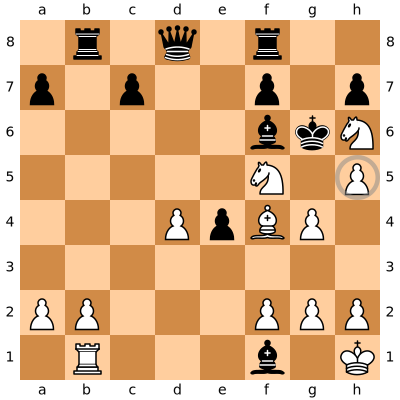

https://lichess.org/JaZSHQvm
black's turn
black/white [CrazyhousePocket('n'), CrazyhousePocket('pppp')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


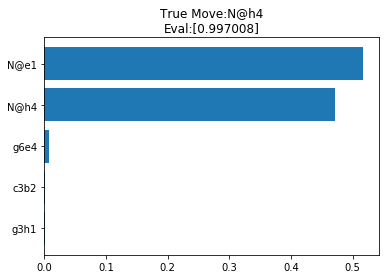

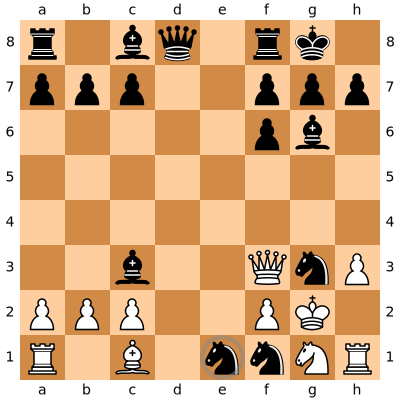

https://lichess.org/aEkH467l
white's turn
black/white [CrazyhousePocket('bpppp'), CrazyhousePocket('r')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


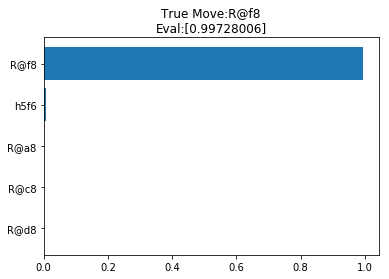

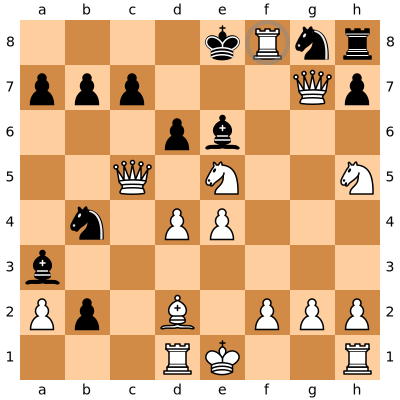

https://lichess.org/AXHqFp0W
white's turn
black/white [CrazyhousePocket('bbbp'), CrazyhousePocket('npp')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


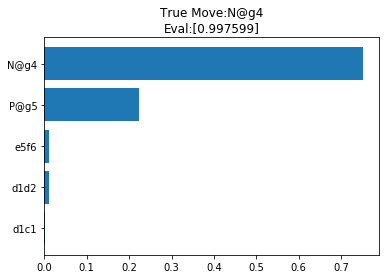

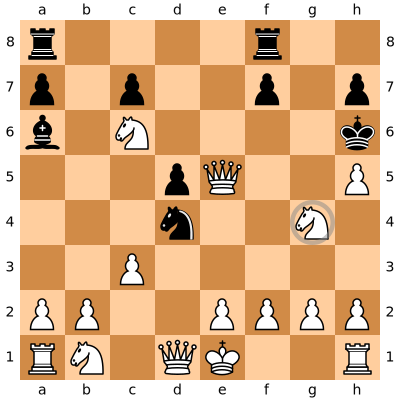

https://lichess.org/koKV9oe5
black's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('nppp')]
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:25 matplotlib.axes._base[27985] DEBUG update_title_pos


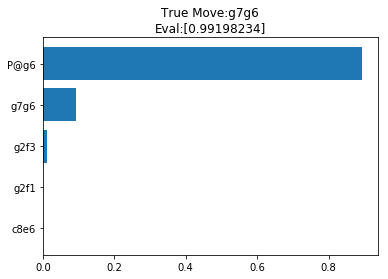

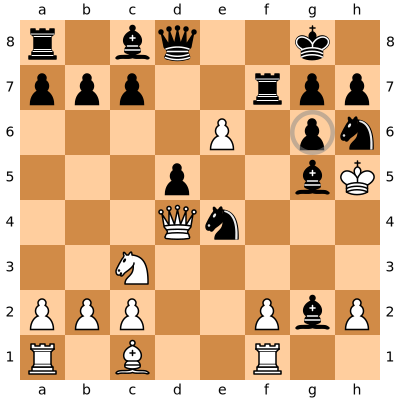

https://lichess.org/l30GAIip
black's turn
black/white [CrazyhousePocket('rbbnpp'), CrazyhousePocket('rp')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos


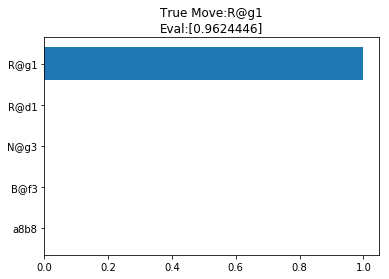

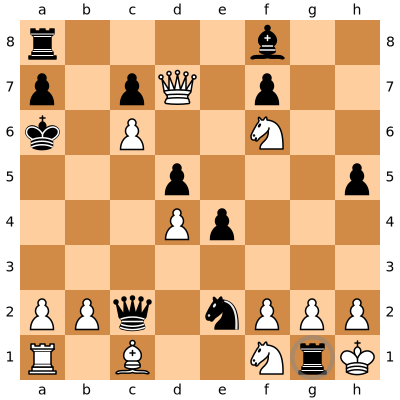

https://lichess.org/qSMyFbYs
white's turn
black/white [CrazyhousePocket('qnn'), CrazyhousePocket('bb')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos


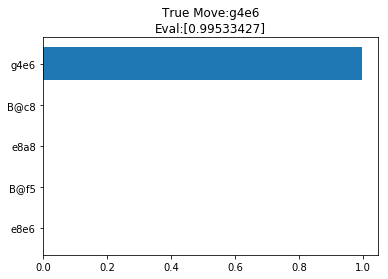

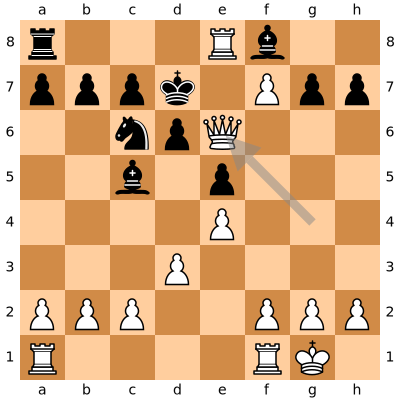

https://lichess.org/CUT8OfGV
white's turn
black/white [CrazyhousePocket('qrbb'), CrazyhousePocket('rnnnpp')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos


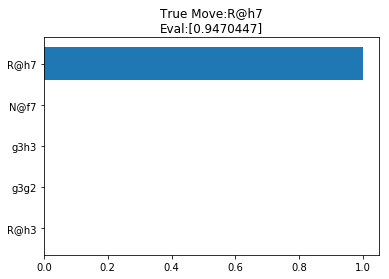

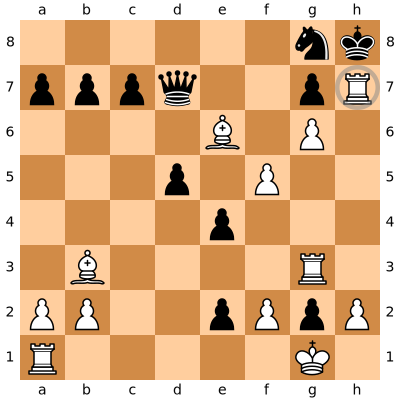

https://lichess.org/N9R4ohE6
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnn')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos


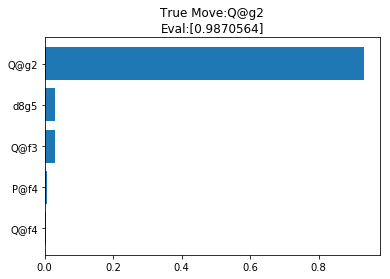

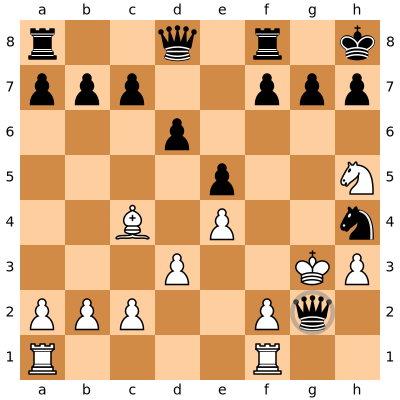

https://lichess.org/uN2inbhr
black's turn
black/white [CrazyhousePocket('q'), CrazyhousePocket('rrppppp')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos


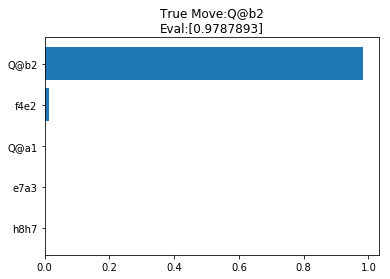

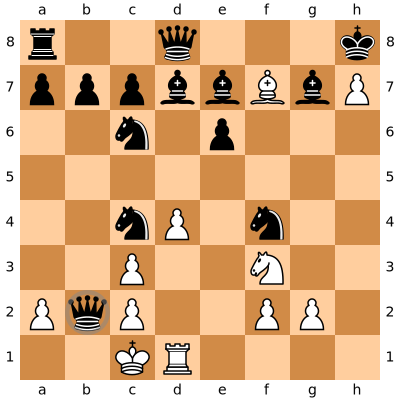

https://lichess.org/N4IMyBUG
black's turn
black/white [CrazyhousePocket('rnppp'), CrazyhousePocket('')]
2019-01-14 09:57:26 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos


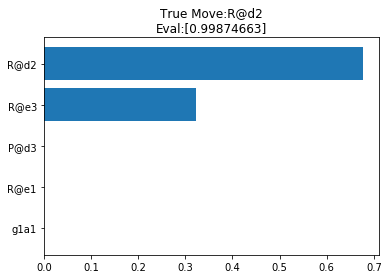

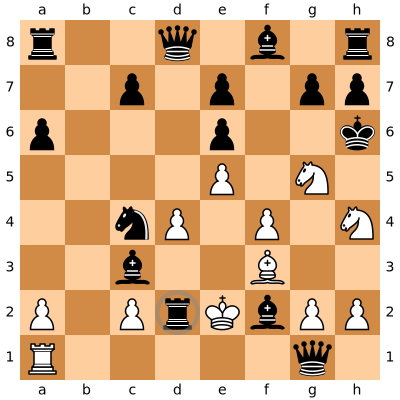

https://lichess.org/wkHxsIKQ
white's turn
black/white [CrazyhousePocket('qbbbnnp'), CrazyhousePocket('rbpp')]
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:27 matplotlib.axes._base[27985] DEBUG update_title_pos


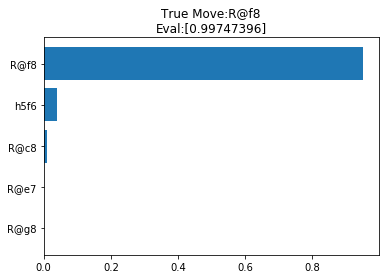

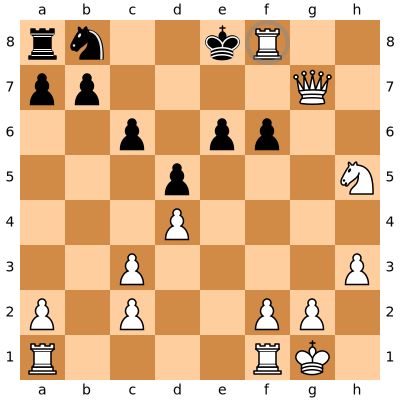

In [61]:
for i in range(17):
    print(clean_string(site_mate[i]))
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True)
    pred_move = pred_moves[0]
    pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
    SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))

## Show examples where it failed

https://lichess.org/5mcYjBhV
white's turn
black/white [CrazyhousePocket('qn'), CrazyhousePocket('p')]
2019-01-14 09:57:33 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:33 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:33 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:33 matplotlib.axes._base[27985] DEBUG update_title_pos


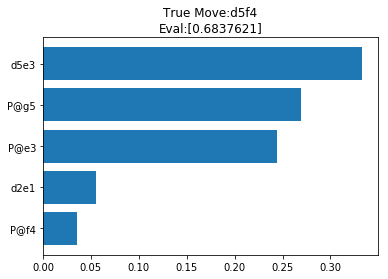

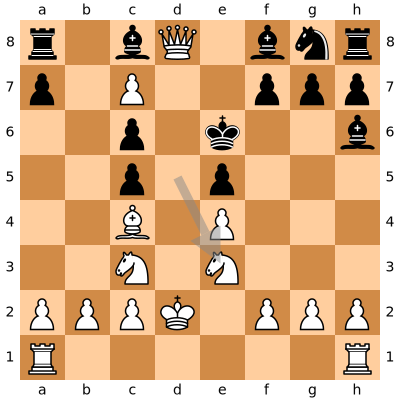

https://lichess.org/jN0L0IDE
black's turn
black/white [CrazyhousePocket('rp'), CrazyhousePocket('')]
2019-01-14 09:57:44 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:44 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:44 matplotlib.axes._base[27985] DEBUG update_title_pos
2019-01-14 09:57:44 matplotlib.axes._base[27985] DEBUG update_title_pos


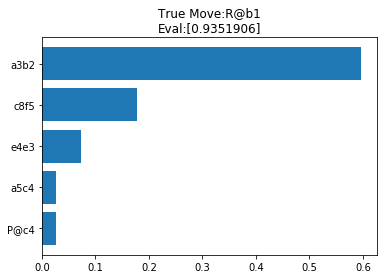

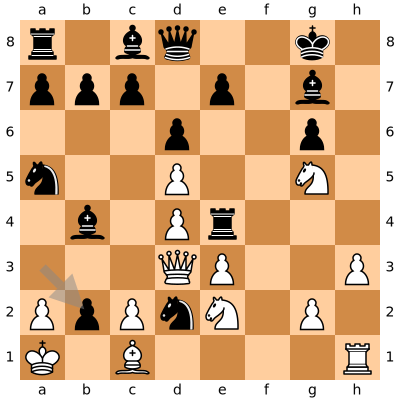

In [62]:
for i in range(1000):
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=False)
    if is_mate_5_top is False:
        print(clean_string(site_mate[i]))
        pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True)
        pred_move = pred_moves[0]
        pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
        SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))